In [3]:
!pip install tqdm
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from itertools import islice
from tqdm import tqdm
import pickle
import torch
from torchvision import transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import time
#from google.colab import drive


24.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [9]:
#download the mnist dataset using torchvision
from torchvision.datasets import MNIST


In [4]:
#defining the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [5]:
# Check if running in Google Colab
def in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Use the defined functions to set the path
if  in_colab():
    # Mount Google Drive (this will require user authorization)
    from google.colab import drive
    drive.mount('/content/drive')
    save_path = '/content/drive/My Drive/Colab Notebooks/Loads_4_Boss_Proj/'
    print("In Colab")
else:
    # Assume we are in VSCode or other local environment
    save_path = './Saves/'
    print("Not in Colab")

#no clue what this does
# Ensure the save directory exists
if not os.path.exists(save_path):
    os.makedirs(save_path)
    print("why?")

Not in Colab


In [6]:
def load_checkpoint(gen, filename):
    # Load the checkpoint
    checkpoint = torch.load(filename)

    # Update models and optimizers
    gen.load_state_dict(checkpoint['gen'])
    # disc.load_state_dict(checkpoint['disc'])
    # gen_opt.load_state_dict(checkpoint['gen_opt'])
    # disc_opt.load_state_dict(checkpoint['disc_opt'])

    # Update the step number if necessary
    step = checkpoint['step']

    print(f"Checkpoint '{filename}' loaded successfully at step {step}.")

In [7]:
# Function to save the model checkpoint
def save_checkpoint(gen, step, filename="checkpoint.pth.tar"):
    filename = f'model_checkpoint_{epoch}.pth'
    filepath = os.path.join(save_path, filename)
    checkpoint = {
        'gen': gen.state_dict(),
        'step': step
    }
    torch.save(checkpoint, filepath)
    print(f'Model saved to {filepath}')

# def save_checkpoint(gen, step, filename="checkpoint.pth.tar"):
#     checkpoint = {
#         'gen': gen.state_dict(),
#         'step': step
#     }
#     torch.save(checkpoint, filename)

In [10]:
# Load MNIST dataset as tensors using DataLoader class
batch_size = 200
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

def tensor_to_images(image_tensor, num_images=16, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=4)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

Failed to download (trying next):
HTTP Error 403: Forbidden



  1%|          | 98304/9912422 [00:00<00:14, 669631.45it/s]0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
100%|██████████| 9912422/9912422 [00:01<00:00, 7408508.27it/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 293799.04it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2518710.86it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1748236.10it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



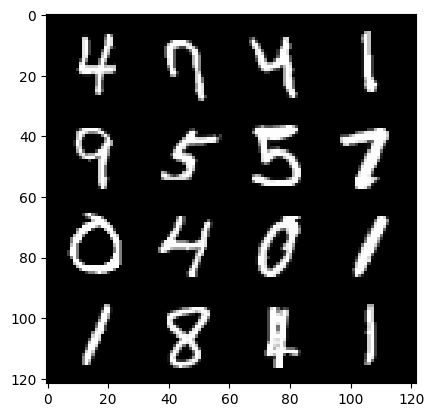

torch.Size([200, 1, 28, 28])

In [12]:
#how does the data look like
sample_img = next(iter(dataloader))
tensor_to_images(sample_img[0])
sample_img[0].shape


In [14]:
class Generator(nn.Module):
    def __init__(self, noise_dimension=15, 
                       image_dimension=784, 
                       hidden_dimension=128):
        super(Generator, self).__init__()
        
        self.n_dim = noise_dimension
        self.i_dim = image_dimension
        self.h_dim = hidden_dimension

        # Generator network
        self.gen = nn.Sequential(
            # First layer - input is noise, output is hidden layer
            nn.Linear(self.n_dim, self.h_dim),
            nn.BatchNorm1d(self.h_dim),
            nn.ReLU(inplace=True),

            # Second layer - doubling up boi
            nn.Linear(self.h_dim, self.h_dim * 2),
            nn.BatchNorm1d(self.h_dim * 2),
            nn.ReLU(inplace=True),

            # Third layer - more neurons, more power, right?
            nn.Linear(self.h_dim * 2, self.h_dim * 4),
            nn.BatchNorm1d(self.h_dim * 4),
            nn.ReLU(inplace=True),

            # Fourth layer - at this point, who even needs sleep?
            nn.Linear(self.h_dim * 4, self.h_dim * 8),
            nn.BatchNorm1d(self.h_dim * 8),
            nn.ReLU(inplace=True),

            # Final layer - let's wrap this up and go to bed
            nn.Linear(self.h_dim * 8, self.i_dim),
            nn.Sigmoid()  # because pixels should be between 0 and 1
        )

    def forward(self, noise):
        return self.gen(noise)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, img_dim=784, hid_dim=128):
        super(Discriminator, self).__init__()
        
        # Discriminator network - because sleep is overrated
        self.disc = nn.Sequential(
            # First layer - starting strong with quadruple hidden dimension
            nn.Linear(img_dim, hid_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # Second layer halving the neurons
            nn.Linear(hid_dim * 4, hid_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # Third layer - neurons are halved again, but who needs even numbers?
            nn.Linear(hid_dim * 2, hid_dim),
            nn.LeakyReLU(0.2, inplace=True),

            # Final layer - because every good story has an end
            nn.Linear(hid_dim, 1)  # Outputting a single value for binary classification
        )

    def forward(self, img):
        # Flattening the image - because who has time for multi-dimensional arrays?
        img = img.view(img.size(0), -1)
        return self.disc(img)

In [18]:
# Hyperparameters for training loop
n_epochs = 200
noise_dimension = 64
lr = 0.00001
display_step = 1000
load_step = 1000
criterion = nn.BCEWithLogitsLoss()


In [19]:
# genrator and choosing the optimizer (in class adam optimizer was said to be the best)
gen = Generator(noise_dimension).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)

# discriminator and choosing the optimizer again (adam)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

print(gen)

Generator(
  (gen): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=1024, out_features=784, bias=True)
    (13): Sigmoid()
  )
)


In [21]:
def creat_noise(num_images, noise_dimension, device=device):
    return torch.randn(num_images, noise_dimension, device=device)

def get_disc_loss(gen, disc, criterion, real, num_images, noise_dimension, device):
    # Generate noise and create fake images
    noise = creat_noise(num_images, noise_dimension, device=device)
    fake = gen(noise)

    # Create real and fake labels
    real_labels = torch.ones(num_images, 1).to(device)
    fake_labels = torch.zeros(num_images, 1).to(device)

    # Compute discriminator loss on real images
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, real_labels)

    # Compute discriminator loss on fake images (detach to avoid backprop to generator)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, fake_labels)

    # Combine real and fake loss
    disc_loss = disc_real_loss + disc_fake_loss
    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, noise_dimension, device):
    # Generate noise and create fake images
    noise = creat_noise(num_images, noise_dimension, device=device)
    fake = gen(noise)

    # Create fake labels (pretend they're real for generator training)
    fake_labels = torch.ones(num_images, 1).to(device)

    # Compute generator loss based on discriminator's prediction
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, fake_labels)
    return gen_loss

In [67]:
#testing the load functionality
# Initialize the gen_loaderator model
# genrator and choosing the optimizer (in class adam optimizer was said to be the best)
gen_load = Generator(noise_dimension).to(device)
# Load the model checkpoint you can choose any model in Saves
checkpoint_path = 'Saves/model_checkpoint_196.pth'
state_dict = torch.load(checkpoint_path)
# Load the state dictionary into the model


# If there are unexpected keys, ignore them and load the state dictionary
missing_keys, unexpected_keys = gen.load_state_dict(state_dict, strict=False)

# Print missing and unexpected keys
if missing_keys:
    print(f'Missing keys: {missing_keys}')
if unexpected_keys:
    print(f'Unexpected keys: {unexpected_keys}')

# Set the model to evaluation mode (if you are using it for inference)
gen_load.eval()


Missing keys: ['gen.0.weight', 'gen.0.bias', 'gen.1.weight', 'gen.1.bias', 'gen.1.running_mean', 'gen.1.running_var', 'gen.3.weight', 'gen.3.bias', 'gen.4.weight', 'gen.4.bias', 'gen.4.running_mean', 'gen.4.running_var', 'gen.6.weight', 'gen.6.bias', 'gen.7.weight', 'gen.7.bias', 'gen.7.running_mean', 'gen.7.running_var', 'gen.9.weight', 'gen.9.bias', 'gen.10.weight', 'gen.10.bias', 'gen.10.running_mean', 'gen.10.running_var', 'gen.12.weight', 'gen.12.bias']
Unexpected keys: ['step']


Generator(
  (gen): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=512, out_features=1024, bias=True)
    (10): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=1024, out_features=784, bias=True)
    (13): Sigmoid()
  )
)

 33%|███▎      | 100/300 [00:07<00:16, 11.99it/s]

Step 1000: Generator loss: 1.5774825608730327, discriminator loss: 0.7194912187457092


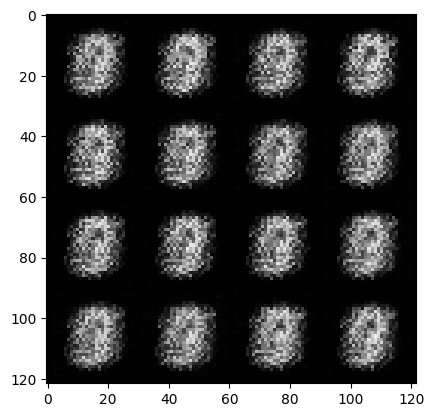

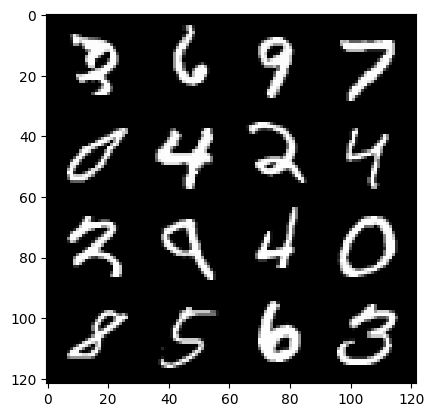

 34%|███▍      | 102/300 [00:08<00:36,  5.42it/s]

Model saved to ./Saves/model_checkpoint_3.pth
Saved checkpoint to: checkpoint_step_1000.pth.tar


 67%|██████▋   | 200/300 [00:16<00:08, 11.49it/s]

Step 2000: Generator loss: 1.8037062560319923, discriminator loss: 0.4235368706881998


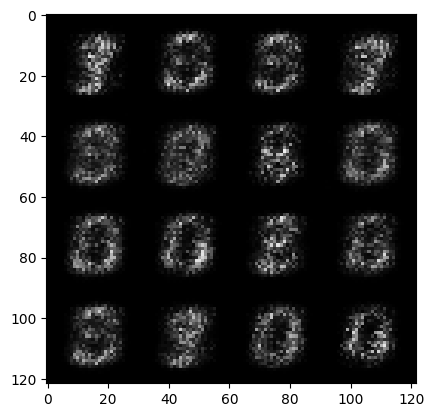

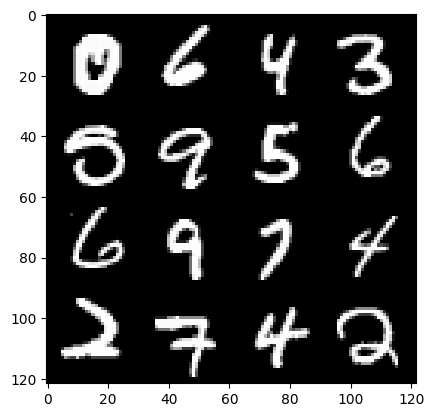

 67%|██████▋   | 202/300 [00:17<00:19,  5.07it/s]

Model saved to ./Saves/model_checkpoint_6.pth
Saved checkpoint to: checkpoint_step_2000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 3000: Generator loss: 1.5499423832893362, discriminator loss: 0.4846202279925349


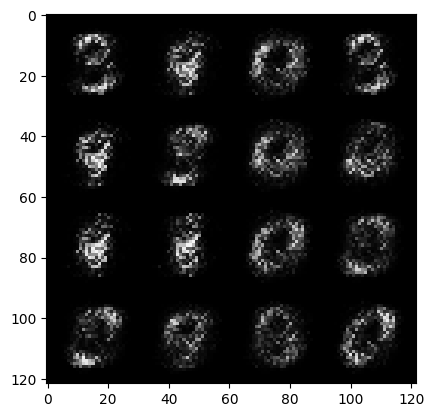

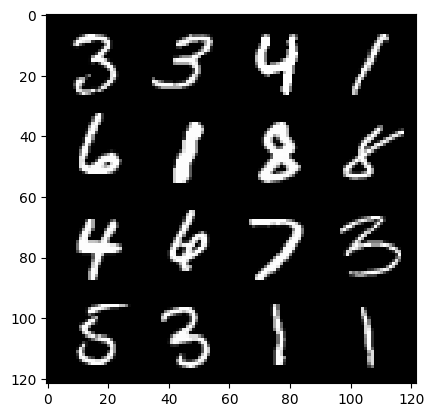

  1%|          | 3/300 [00:00<01:12,  4.12it/s]

Model saved to ./Saves/model_checkpoint_10.pth
Saved checkpoint to: checkpoint_step_3000.pth.tar


 33%|███▎      | 100/300 [00:08<00:15, 12.87it/s]

Step 4000: Generator loss: 2.116728003025058, discriminator loss: 0.35678220048546766


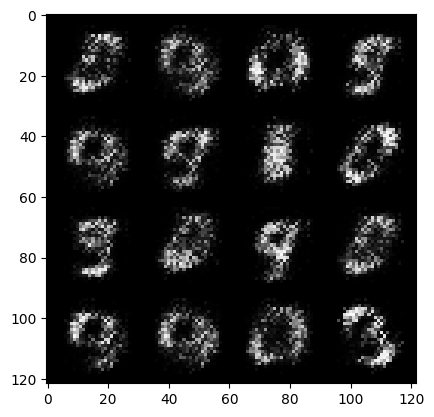

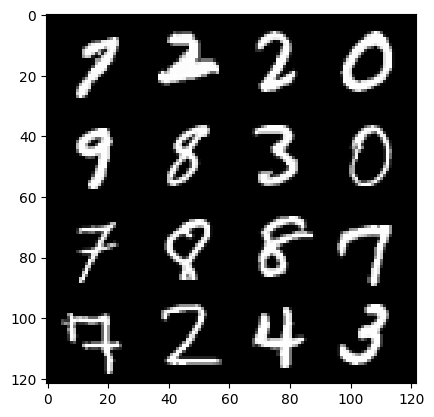

 34%|███▍      | 102/300 [00:08<00:34,  5.79it/s]

Model saved to ./Saves/model_checkpoint_13.pth
Saved checkpoint to: checkpoint_step_4000.pth.tar


 67%|██████▋   | 200/300 [00:15<00:08, 12.42it/s]

Step 5000: Generator loss: 2.7881651337146747, discriminator loss: 0.25305300916731344


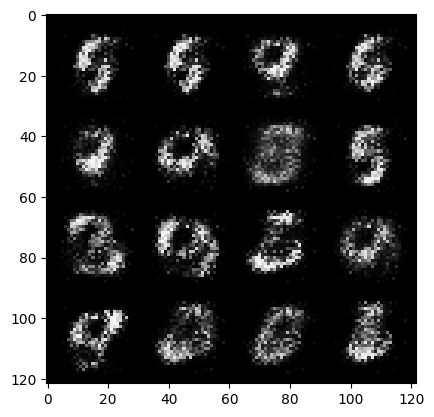

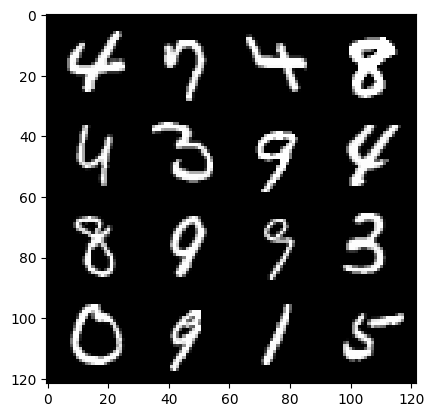

 67%|██████▋   | 202/300 [00:16<00:17,  5.69it/s]

Model saved to ./Saves/model_checkpoint_16.pth
Saved checkpoint to: checkpoint_step_5000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 6000: Generator loss: 3.3205153751373273, discriminator loss: 0.1670405768901108


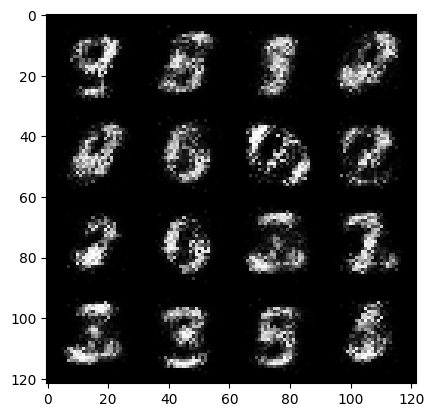

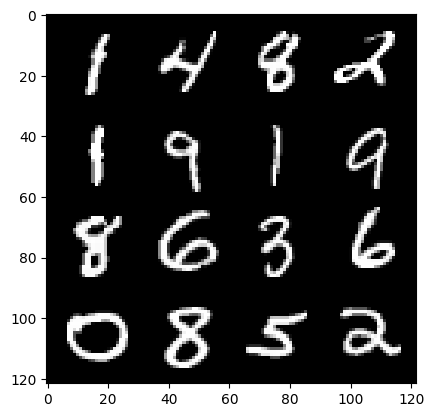

  1%|          | 3/300 [00:01<01:24,  3.53it/s]

Model saved to ./Saves/model_checkpoint_20.pth
Saved checkpoint to: checkpoint_step_6000.pth.tar


 33%|███▎      | 100/300 [00:07<00:15, 12.59it/s]

Step 7000: Generator loss: 3.6850081503391254, discriminator loss: 0.12965318901836861


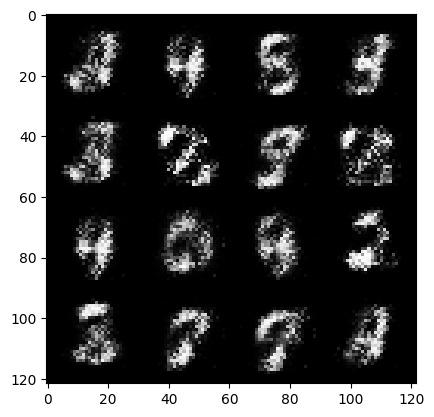

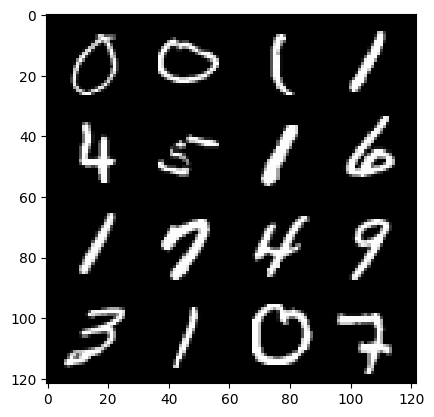

 34%|███▍      | 102/300 [00:08<00:38,  5.08it/s]

Model saved to ./Saves/model_checkpoint_23.pth
Saved checkpoint to: checkpoint_step_7000.pth.tar


 66%|██████▋   | 199/300 [00:16<00:07, 13.23it/s]

Step 8000: Generator loss: 3.6912580955028504, discriminator loss: 0.15348344286531232


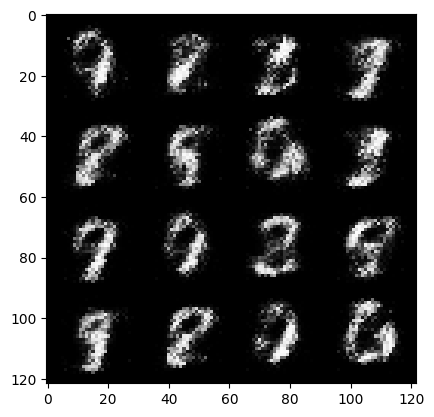

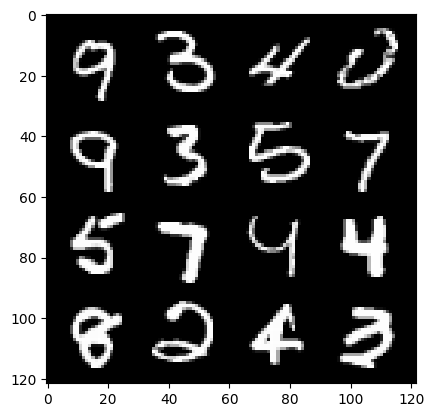

 68%|██████▊   | 203/300 [00:17<00:13,  6.97it/s]

Model saved to ./Saves/model_checkpoint_26.pth
Saved checkpoint to: checkpoint_step_8000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 9000: Generator loss: 4.048431352376939, discriminator loss: 0.1270340766385196


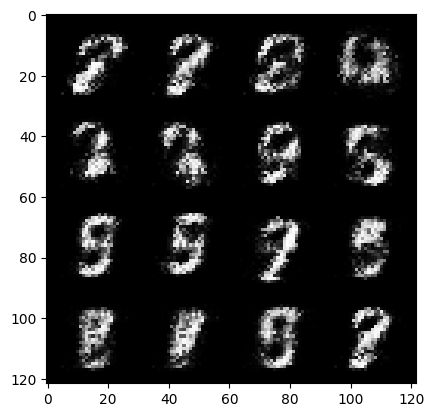

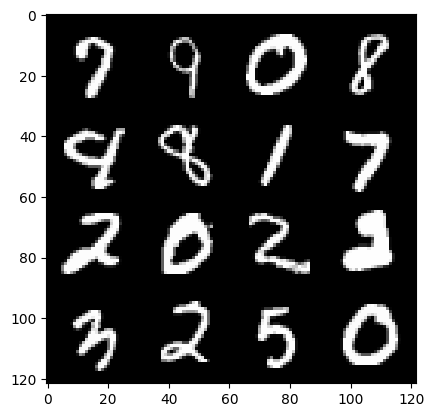

  1%|          | 3/300 [00:00<01:11,  4.14it/s]

Model saved to ./Saves/model_checkpoint_30.pth
Saved checkpoint to: checkpoint_step_9000.pth.tar


 33%|███▎      | 100/300 [00:07<00:14, 13.37it/s]

Step 10000: Generator loss: 4.063969842910771, discriminator loss: 0.1287263864725827


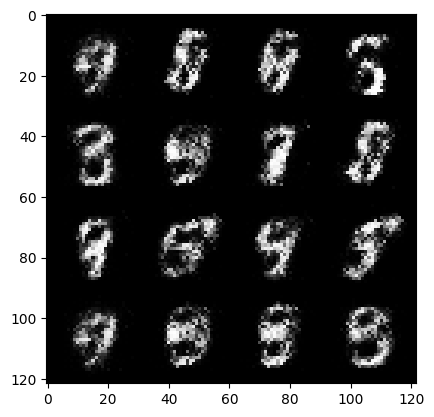

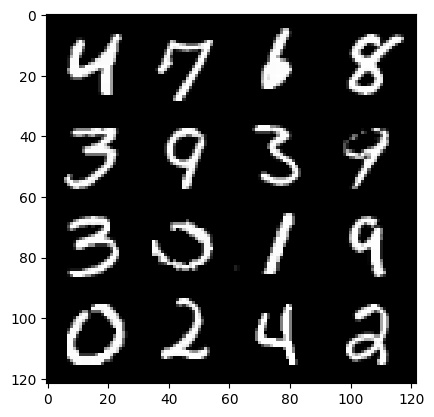

 34%|███▍      | 102/300 [00:08<00:32,  6.00it/s]

Model saved to ./Saves/model_checkpoint_33.pth
Saved checkpoint to: checkpoint_step_10000.pth.tar


 67%|██████▋   | 200/300 [00:15<00:07, 13.29it/s]

Step 11000: Generator loss: 4.142612727403638, discriminator loss: 0.13233603813499203


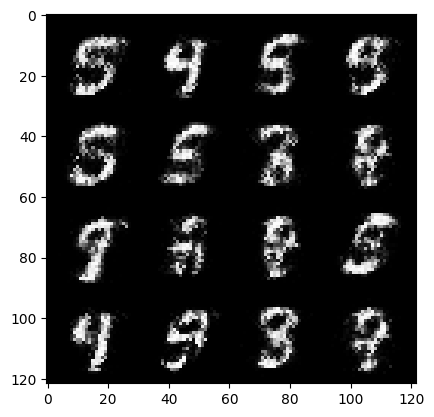

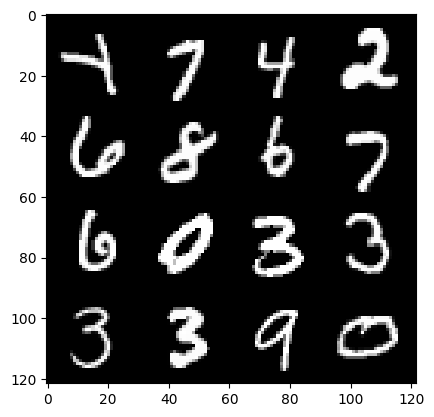

 67%|██████▋   | 202/300 [00:15<00:17,  5.62it/s]

Model saved to ./Saves/model_checkpoint_36.pth
Saved checkpoint to: checkpoint_step_11000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 12000: Generator loss: 3.9160523746013687, discriminator loss: 0.1450244209431112


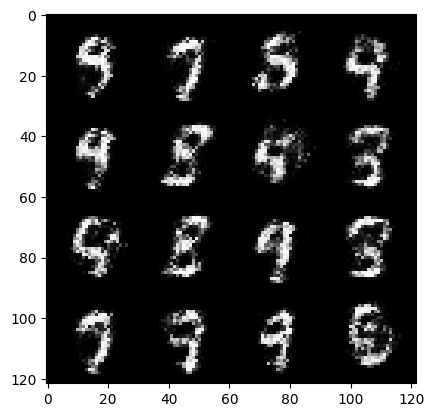

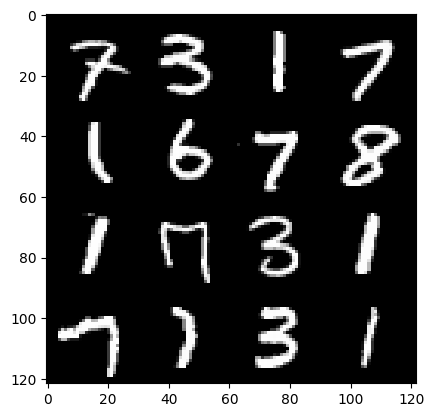

  1%|          | 3/300 [00:00<01:12,  4.08it/s]

Model saved to ./Saves/model_checkpoint_40.pth
Saved checkpoint to: checkpoint_step_12000.pth.tar


 33%|███▎      | 100/300 [00:07<00:14, 13.41it/s]

Step 13000: Generator loss: 4.079390049219132, discriminator loss: 0.15479170945286758


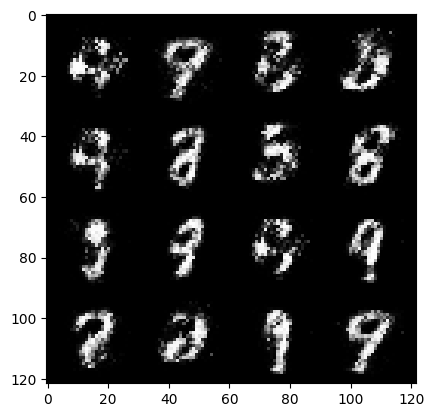

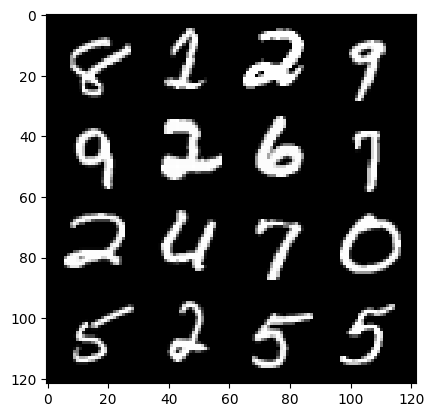

 34%|███▍      | 102/300 [00:08<00:32,  6.12it/s]

Model saved to ./Saves/model_checkpoint_43.pth
Saved checkpoint to: checkpoint_step_13000.pth.tar


 67%|██████▋   | 200/300 [00:14<00:07, 13.21it/s]

Step 14000: Generator loss: 4.0387258534431485, discriminator loss: 0.1871980125084519


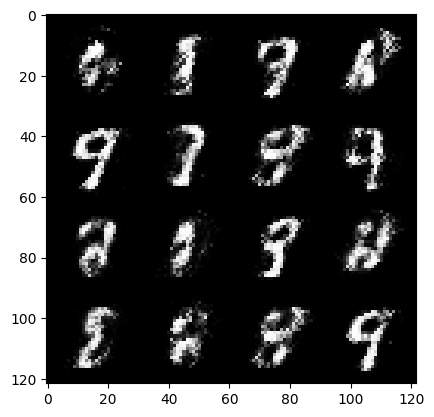

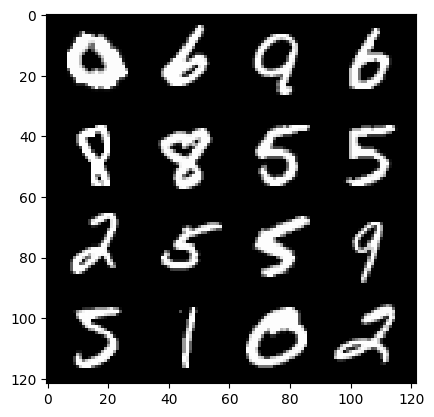

 67%|██████▋   | 202/300 [00:15<00:16,  5.93it/s]

Model saved to ./Saves/model_checkpoint_46.pth
Saved checkpoint to: checkpoint_step_14000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 15000: Generator loss: 3.9527628328800186, discriminator loss: 0.1777129207476974


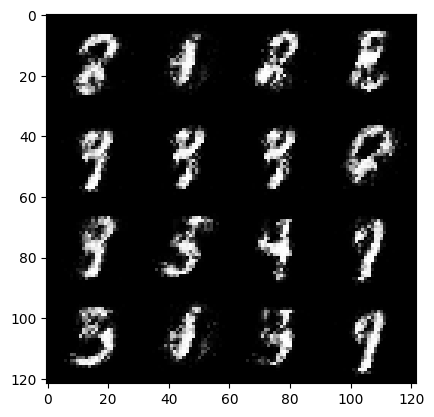

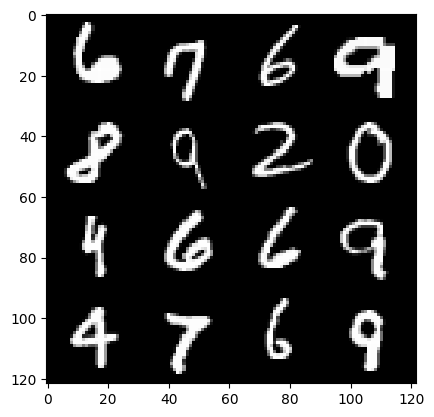

  1%|          | 3/300 [00:00<01:07,  4.37it/s]

Model saved to ./Saves/model_checkpoint_50.pth
Saved checkpoint to: checkpoint_step_15000.pth.tar


 33%|███▎      | 100/300 [00:07<00:15, 13.20it/s]

Step 16000: Generator loss: 3.929198135614391, discriminator loss: 0.1918228063359856


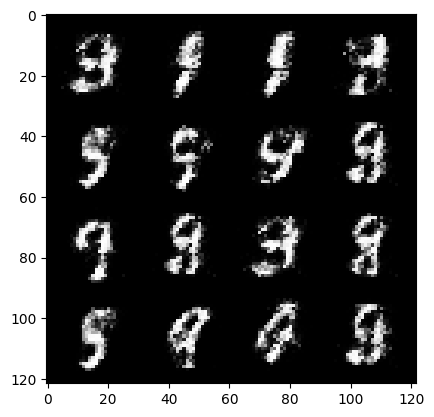

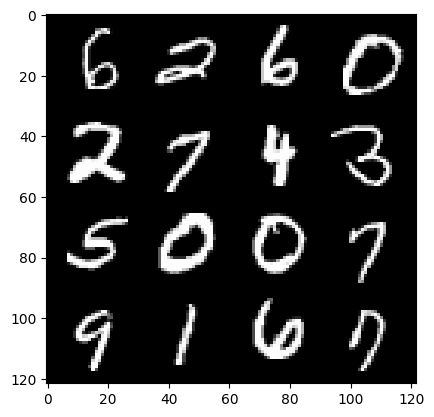

 34%|███▍      | 102/300 [00:08<00:33,  5.99it/s]

Model saved to ./Saves/model_checkpoint_53.pth
Saved checkpoint to: checkpoint_step_16000.pth.tar


 66%|██████▋   | 199/300 [00:18<00:08, 12.19it/s]

Step 17000: Generator loss: 3.836243015289307, discriminator loss: 0.1996048067957165


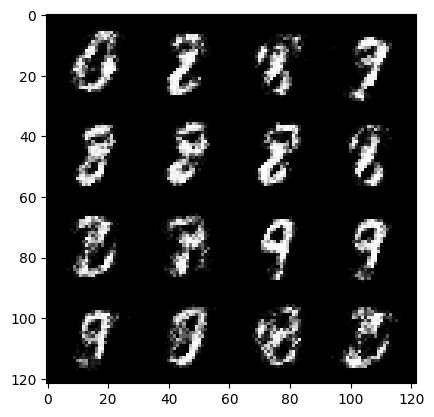

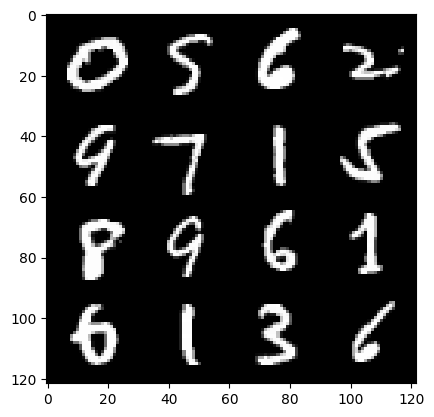

 68%|██████▊   | 203/300 [00:19<00:14,  6.63it/s]

Model saved to ./Saves/model_checkpoint_56.pth
Saved checkpoint to: checkpoint_step_17000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 18000: Generator loss: 3.920720993518833, discriminator loss: 0.20747115627676252


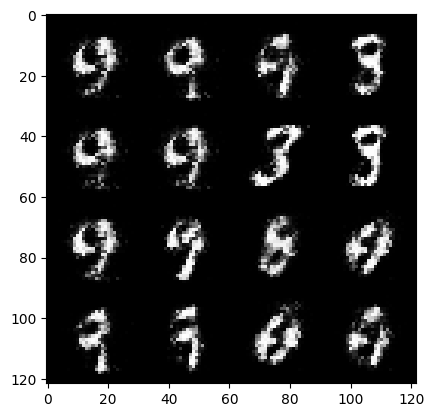

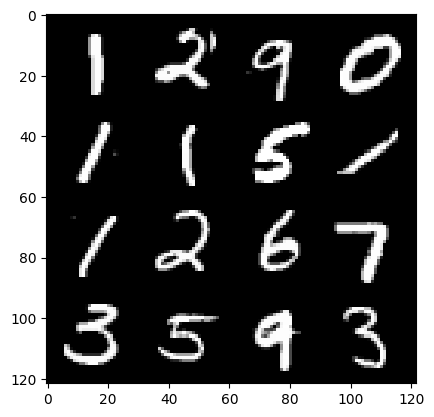

  1%|          | 3/300 [00:00<01:15,  3.93it/s]

Model saved to ./Saves/model_checkpoint_60.pth
Saved checkpoint to: checkpoint_step_18000.pth.tar


 33%|███▎      | 100/300 [00:07<00:14, 13.67it/s]

Step 19000: Generator loss: 3.5339965767860395, discriminator loss: 0.25617804458737387


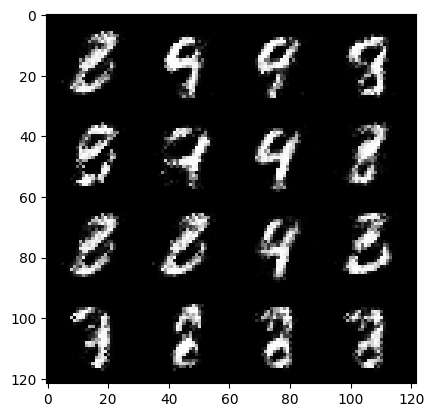

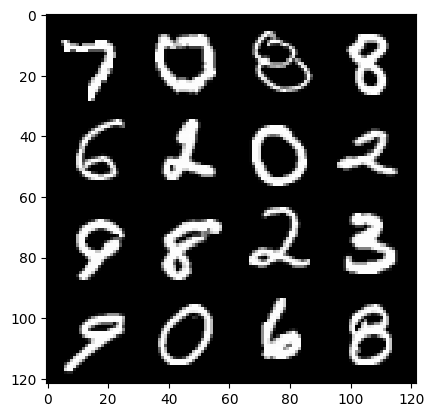

 34%|███▍      | 102/300 [00:08<00:32,  6.13it/s]

Model saved to ./Saves/model_checkpoint_63.pth
Saved checkpoint to: checkpoint_step_19000.pth.tar


 67%|██████▋   | 200/300 [00:15<00:07, 13.55it/s]

Step 20000: Generator loss: 3.531921562194827, discriminator loss: 0.24198176336288457


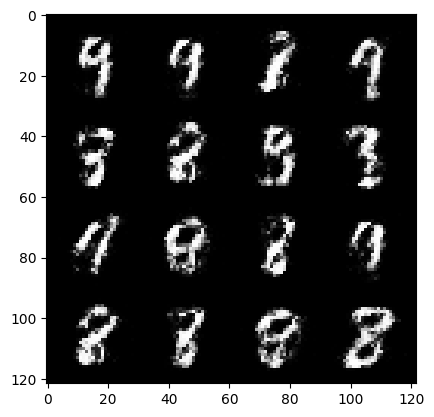

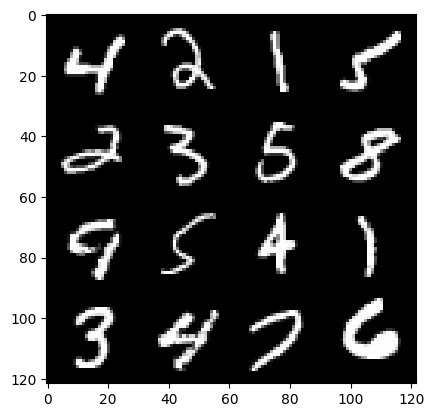

 67%|██████▋   | 202/300 [00:15<00:15,  6.13it/s]

Model saved to ./Saves/model_checkpoint_66.pth
Saved checkpoint to: checkpoint_step_20000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 21000: Generator loss: 3.3656343510150943, discriminator loss: 0.28664791163802145


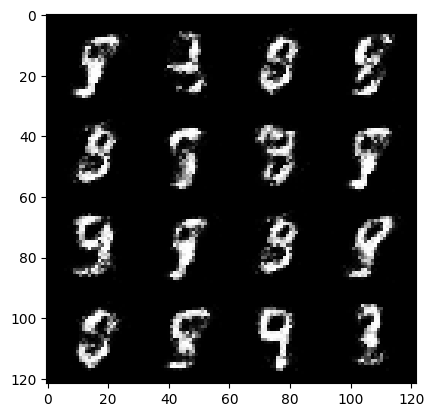

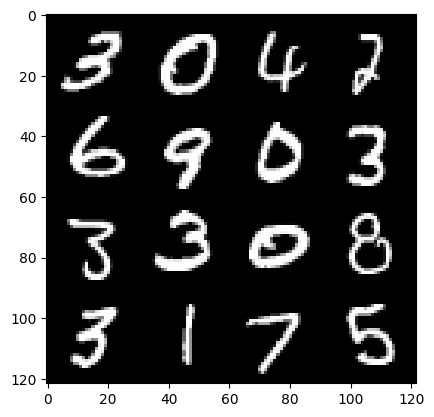

  1%|          | 3/300 [00:00<01:20,  3.71it/s]

Model saved to ./Saves/model_checkpoint_70.pth
Saved checkpoint to: checkpoint_step_21000.pth.tar


 33%|███▎      | 100/300 [00:07<00:15, 12.97it/s]

Step 22000: Generator loss: 3.217774487257003, discriminator loss: 0.29247712941467724


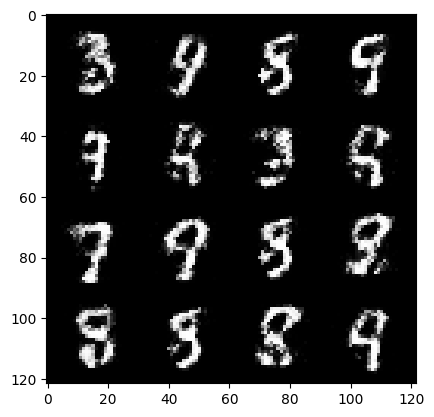

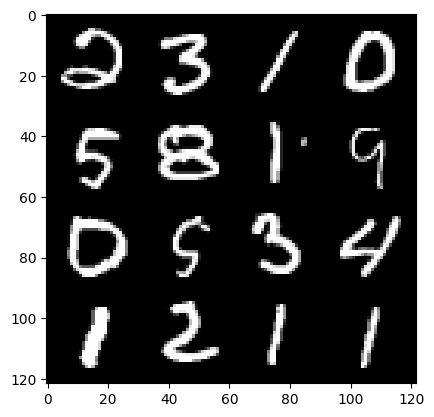

 34%|███▍      | 102/300 [00:08<00:33,  5.87it/s]

Model saved to ./Saves/model_checkpoint_73.pth
Saved checkpoint to: checkpoint_step_22000.pth.tar


 67%|██████▋   | 200/300 [00:15<00:07, 13.02it/s]

Step 23000: Generator loss: 3.306780089139936, discriminator loss: 0.28597225089371175


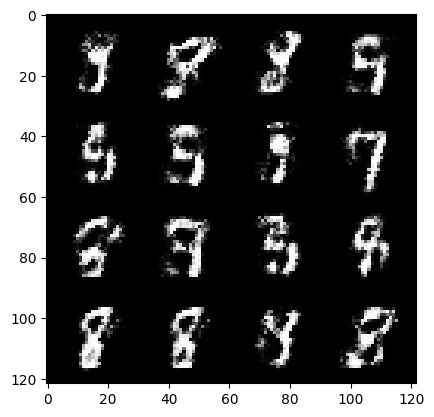

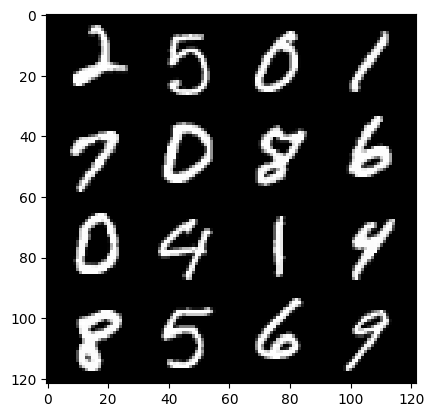

 67%|██████▋   | 202/300 [00:16<00:16,  5.94it/s]

Model saved to ./Saves/model_checkpoint_76.pth
Saved checkpoint to: checkpoint_step_23000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 24000: Generator loss: 3.0932831811904875, discriminator loss: 0.33973351360857507


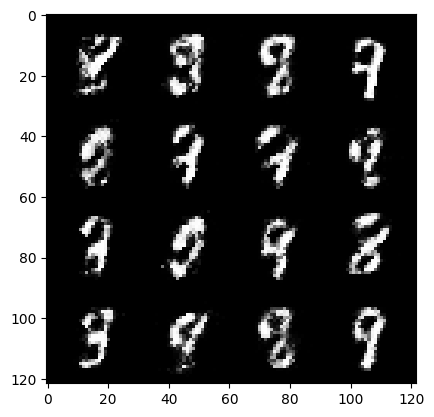

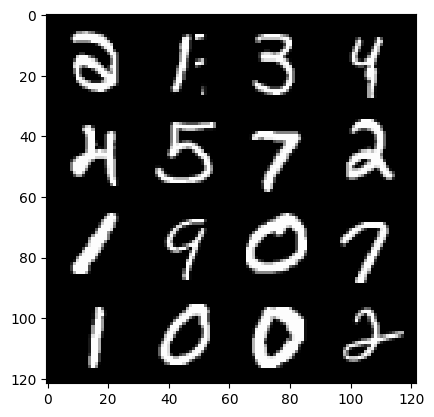

  1%|          | 3/300 [00:00<01:15,  3.93it/s]

Model saved to ./Saves/model_checkpoint_80.pth
Saved checkpoint to: checkpoint_step_24000.pth.tar


 33%|███▎      | 100/300 [00:07<00:14, 14.04it/s]

Step 25000: Generator loss: 3.098397570610051, discriminator loss: 0.33093777060508767


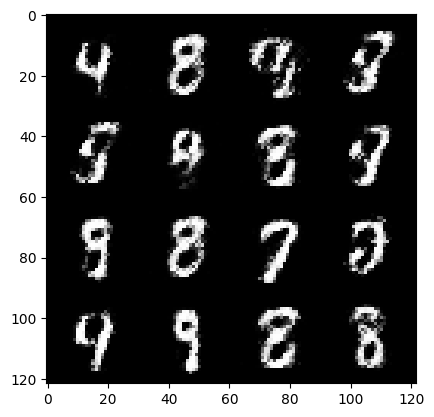

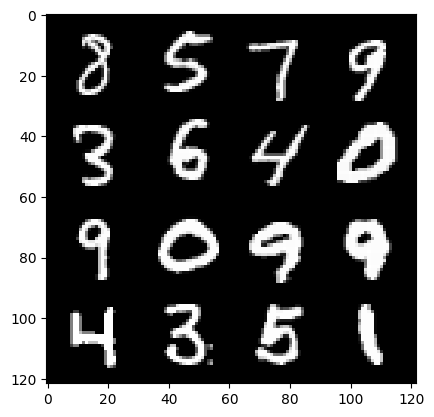

 34%|███▍      | 102/300 [00:07<00:31,  6.37it/s]

Model saved to ./Saves/model_checkpoint_83.pth
Saved checkpoint to: checkpoint_step_25000.pth.tar


 67%|██████▋   | 200/300 [00:15<00:07, 13.21it/s]

Step 26000: Generator loss: 3.0625979635715512, discriminator loss: 0.33703247082233456


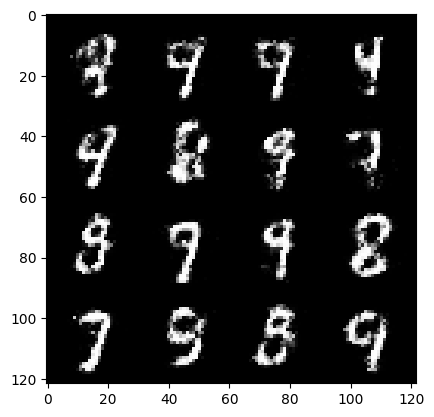

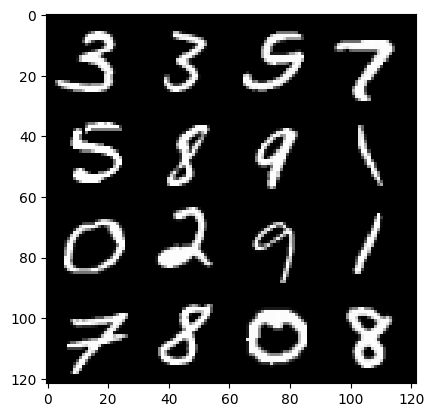

 67%|██████▋   | 202/300 [00:16<00:16,  6.04it/s]

Model saved to ./Saves/model_checkpoint_86.pth
Saved checkpoint to: checkpoint_step_26000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 27000: Generator loss: 3.0743384857177722, discriminator loss: 0.3324601035118101


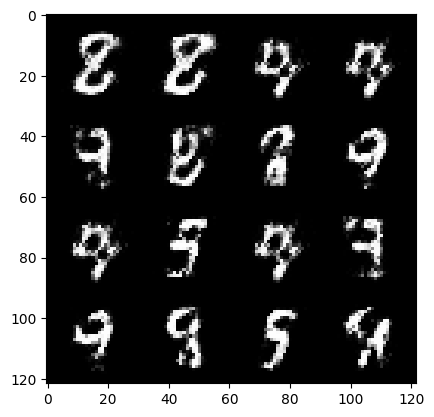

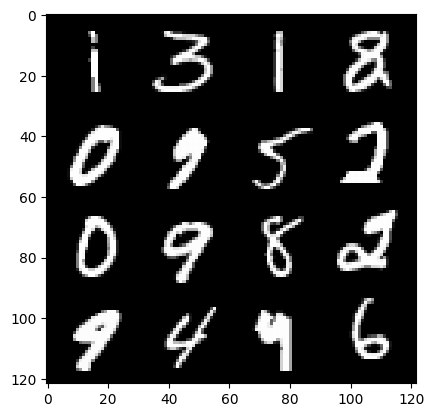

  1%|          | 3/300 [00:00<01:12,  4.10it/s]

Model saved to ./Saves/model_checkpoint_90.pth
Saved checkpoint to: checkpoint_step_27000.pth.tar


 33%|███▎      | 100/300 [00:07<00:14, 13.65it/s]

Step 28000: Generator loss: 2.9022403759956417, discriminator loss: 0.372144671410322


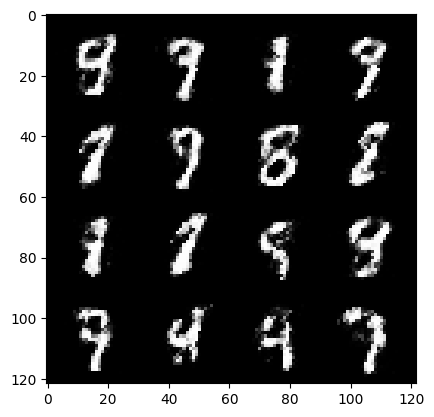

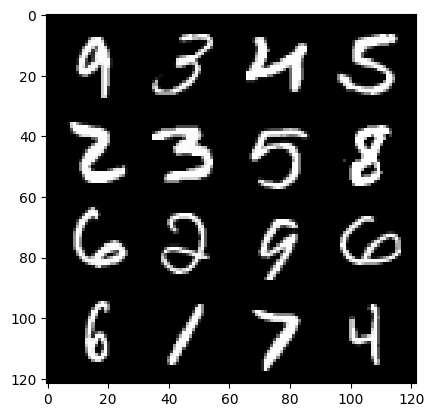

 34%|███▍      | 102/300 [00:08<00:32,  6.13it/s]

Model saved to ./Saves/model_checkpoint_93.pth
Saved checkpoint to: checkpoint_step_28000.pth.tar


 67%|██████▋   | 200/300 [00:14<00:07, 13.57it/s]

Step 29000: Generator loss: 2.8594104361534125, discriminator loss: 0.3745714119970794


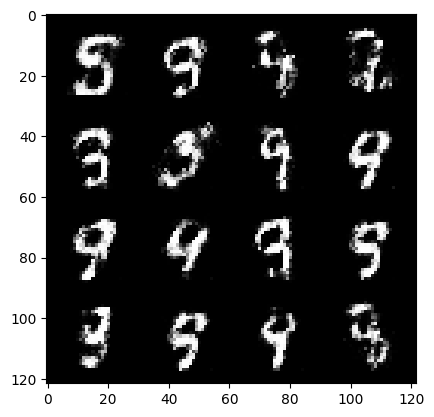

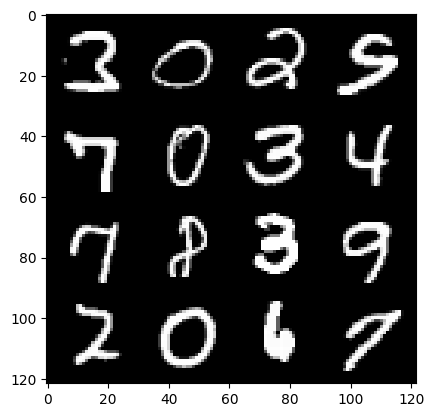

 67%|██████▋   | 202/300 [00:15<00:16,  5.88it/s]

Model saved to ./Saves/model_checkpoint_96.pth
Saved checkpoint to: checkpoint_step_29000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 30000: Generator loss: 2.867505956411364, discriminator loss: 0.3931564517915246


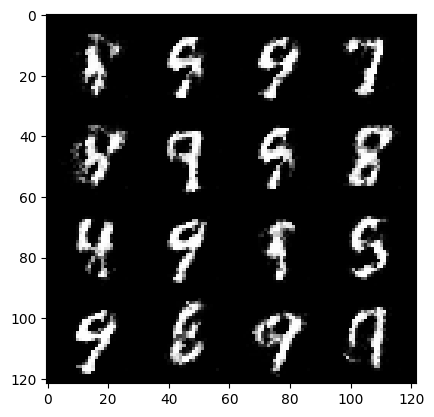

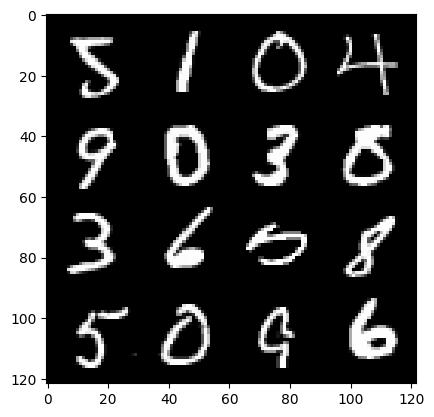

  1%|          | 3/300 [00:00<01:21,  3.64it/s]

Model saved to ./Saves/model_checkpoint_100.pth
Saved checkpoint to: checkpoint_step_30000.pth.tar


 33%|███▎      | 100/300 [00:07<00:14, 13.44it/s]

Step 31000: Generator loss: 2.7381538586616547, discriminator loss: 0.3989115022271873


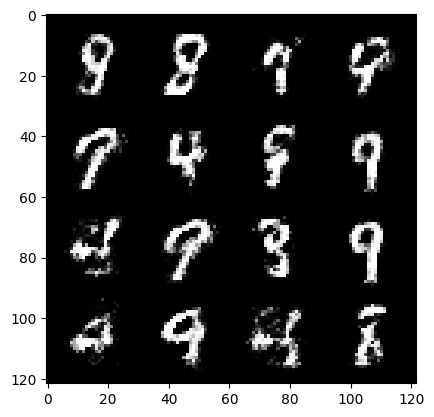

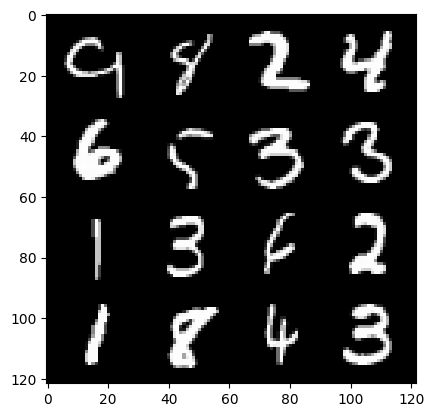

 34%|███▍      | 102/300 [00:08<00:32,  6.04it/s]

Model saved to ./Saves/model_checkpoint_103.pth
Saved checkpoint to: checkpoint_step_31000.pth.tar


 67%|██████▋   | 200/300 [00:14<00:07, 13.50it/s]

Step 32000: Generator loss: 2.7477178847789756, discriminator loss: 0.4035267475694425


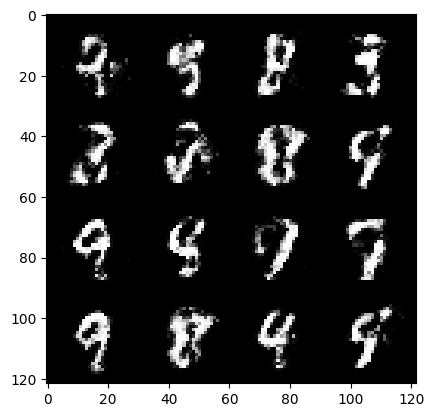

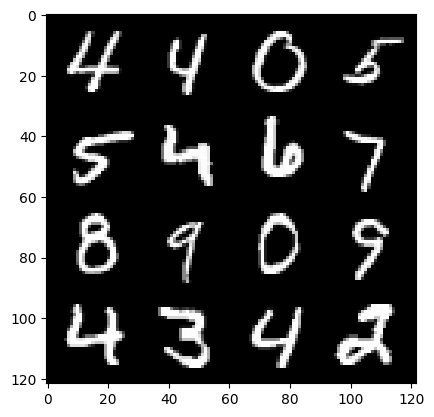

 67%|██████▋   | 202/300 [00:15<00:16,  6.08it/s]

Model saved to ./Saves/model_checkpoint_106.pth
Saved checkpoint to: checkpoint_step_32000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 33000: Generator loss: 2.720868524789812, discriminator loss: 0.4139118886291981


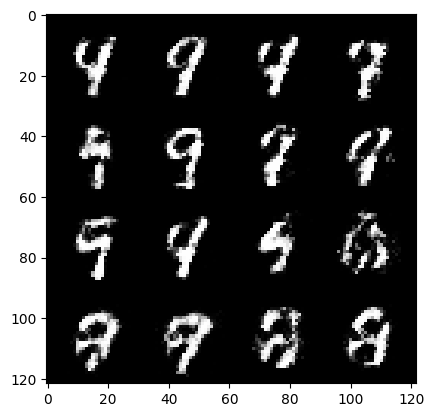

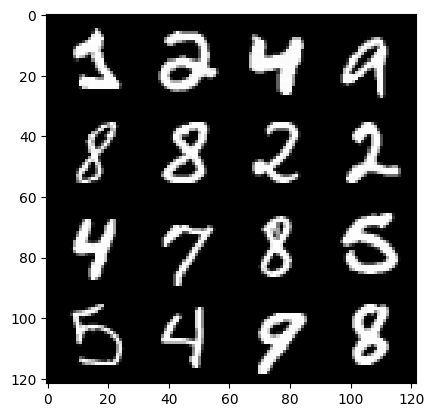

  1%|          | 3/300 [00:00<01:17,  3.84it/s]

Model saved to ./Saves/model_checkpoint_110.pth
Saved checkpoint to: checkpoint_step_33000.pth.tar


 33%|███▎      | 100/300 [00:07<00:14, 13.75it/s]

Step 34000: Generator loss: 2.60077624225616, discriminator loss: 0.4690935231149202


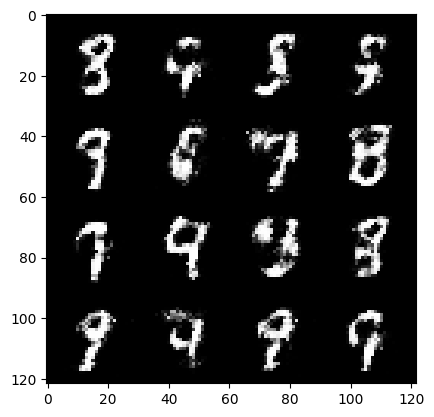

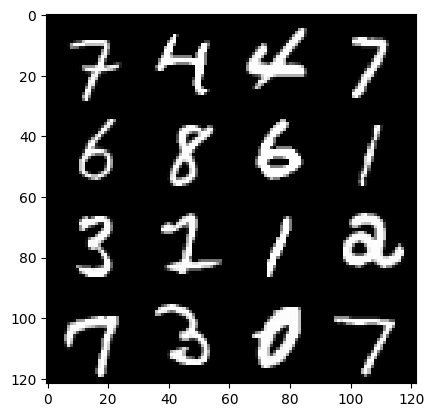

 34%|███▍      | 102/300 [00:08<00:33,  5.95it/s]

Model saved to ./Saves/model_checkpoint_113.pth
Saved checkpoint to: checkpoint_step_34000.pth.tar


 67%|██████▋   | 200/300 [03:24<00:27,  3.67it/s] 

Step 35000: Generator loss: 2.504648851871488, discriminator loss: 0.48014986625313705


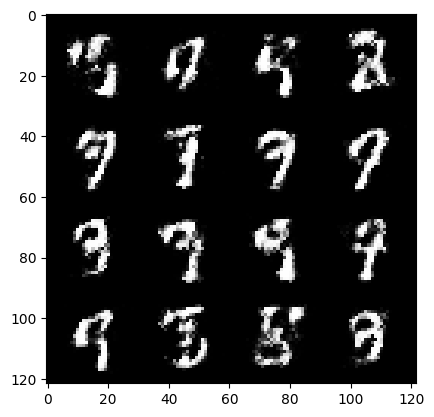

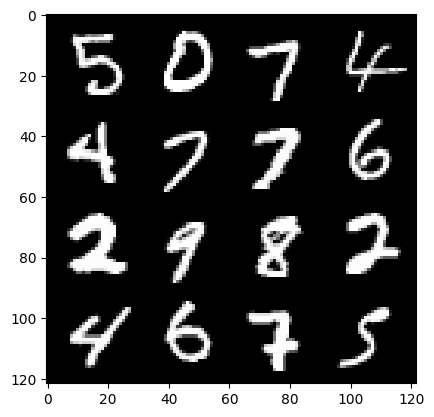

 67%|██████▋   | 201/300 [03:26<01:26,  1.14it/s]

Model saved to ./Saves/model_checkpoint_116.pth
Saved checkpoint to: checkpoint_step_35000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 36000: Generator loss: 2.5900132825374587, discriminator loss: 0.46073057535290735


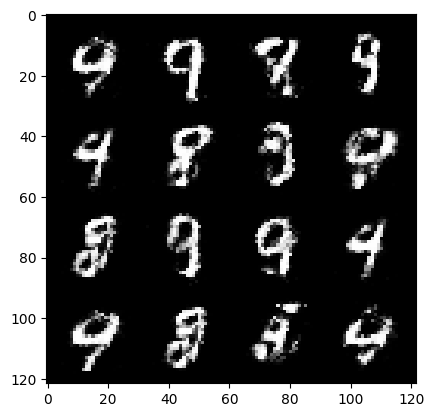

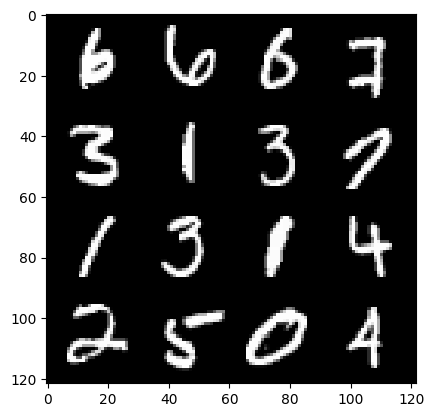

  1%|          | 3/300 [00:00<01:20,  3.69it/s]

Model saved to ./Saves/model_checkpoint_120.pth
Saved checkpoint to: checkpoint_step_36000.pth.tar


 33%|███▎      | 100/300 [00:07<00:16, 12.26it/s]

Step 37000: Generator loss: 2.4212679337263086, discriminator loss: 0.5118593026697636


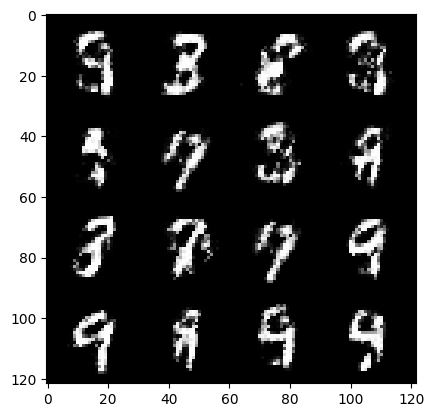

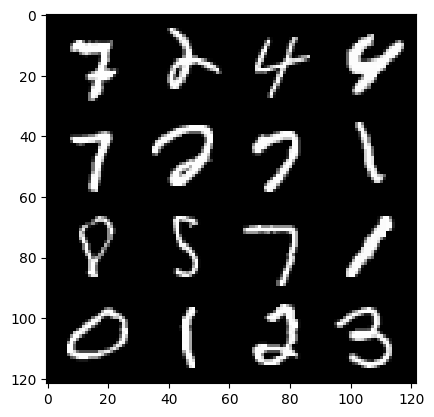

 34%|███▍      | 102/300 [00:08<00:34,  5.69it/s]

Model saved to ./Saves/model_checkpoint_123.pth
Saved checkpoint to: checkpoint_step_37000.pth.tar


 67%|██████▋   | 200/300 [00:16<00:09, 10.54it/s]

Step 38000: Generator loss: 2.35218798840046, discriminator loss: 0.5215251654684541


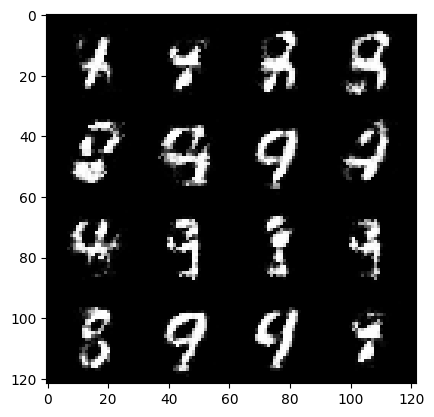

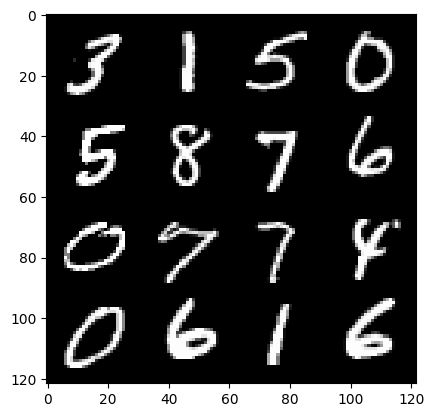

 67%|██████▋   | 202/300 [00:16<00:17,  5.57it/s]

Model saved to ./Saves/model_checkpoint_126.pth
Saved checkpoint to: checkpoint_step_38000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 39000: Generator loss: 2.345065612196925, discriminator loss: 0.51773132494092


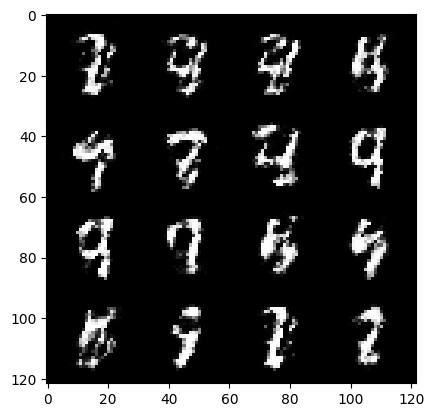

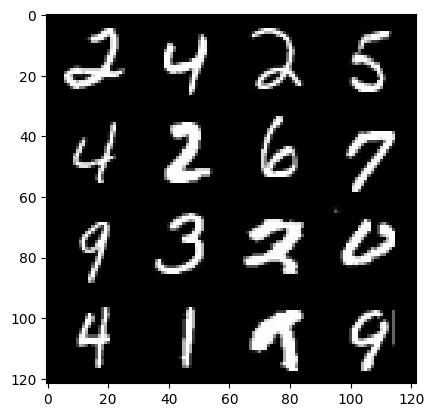

  1%|          | 3/300 [00:00<01:06,  4.50it/s]

Model saved to ./Saves/model_checkpoint_130.pth
Saved checkpoint to: checkpoint_step_39000.pth.tar


 33%|███▎      | 100/300 [00:07<00:14, 13.61it/s]

Step 40000: Generator loss: 2.278033882141117, discriminator loss: 0.5440457314848901


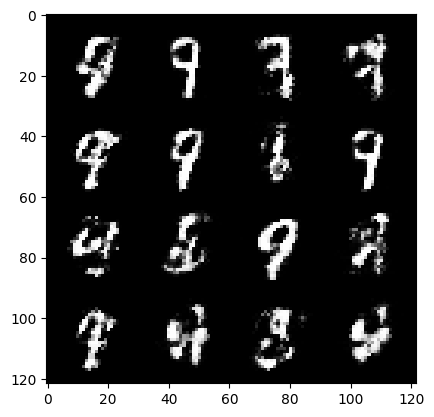

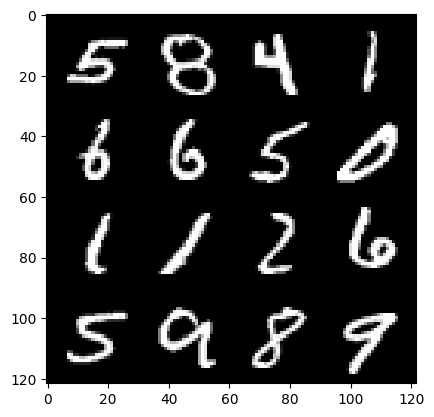

 34%|███▍      | 102/300 [00:08<00:31,  6.26it/s]

Model saved to ./Saves/model_checkpoint_133.pth
Saved checkpoint to: checkpoint_step_40000.pth.tar


 67%|██████▋   | 200/300 [00:14<00:07, 13.45it/s]

Step 41000: Generator loss: 2.2834342864751807, discriminator loss: 0.5395555633604531


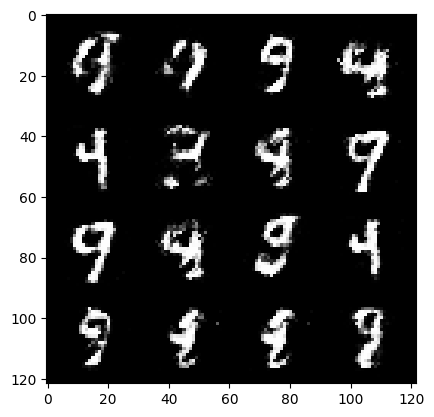

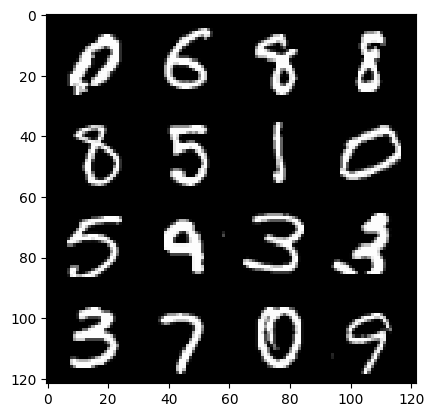

 67%|██████▋   | 202/300 [00:15<00:15,  6.24it/s]

Model saved to ./Saves/model_checkpoint_136.pth
Saved checkpoint to: checkpoint_step_41000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 42000: Generator loss: 2.31607394230366, discriminator loss: 0.5129564567506315


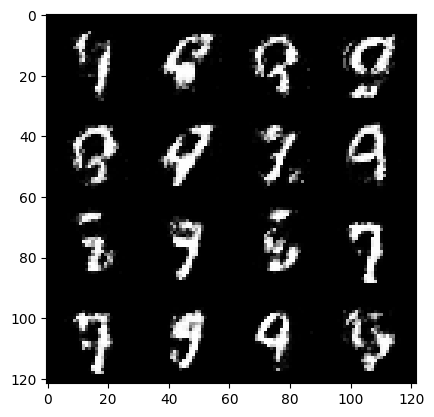

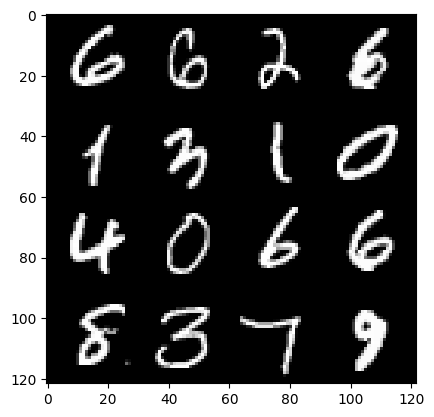

  1%|          | 3/300 [00:00<01:22,  3.60it/s]

Model saved to ./Saves/model_checkpoint_140.pth
Saved checkpoint to: checkpoint_step_42000.pth.tar


 33%|███▎      | 100/300 [00:08<00:17, 11.61it/s]

Step 43000: Generator loss: 2.2433651753663995, discriminator loss: 0.5454487242400651


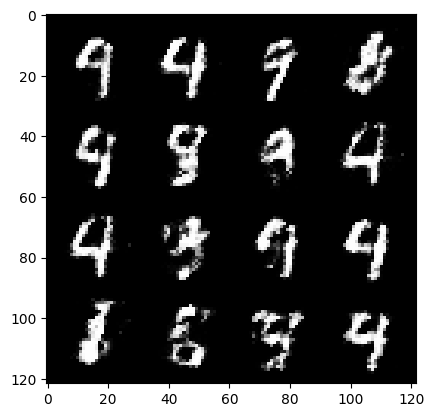

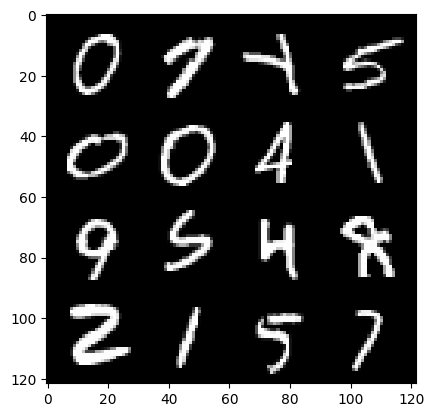

 34%|███▍      | 102/300 [00:09<00:37,  5.22it/s]

Model saved to ./Saves/model_checkpoint_143.pth
Saved checkpoint to: checkpoint_step_43000.pth.tar


 67%|██████▋   | 200/300 [00:16<00:08, 12.11it/s]

Step 44000: Generator loss: 2.2532618032693867, discriminator loss: 0.5431000022292143


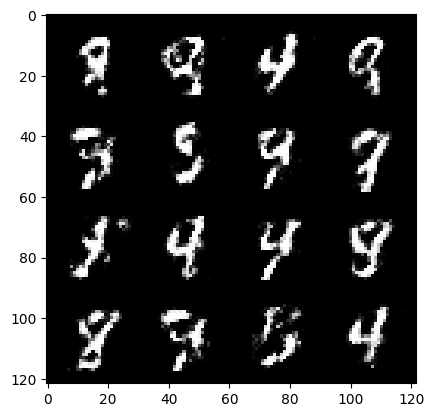

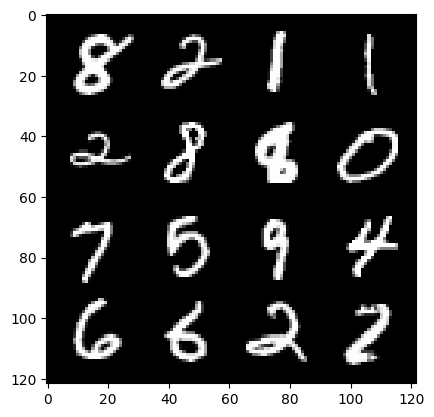

 67%|██████▋   | 202/300 [00:17<00:16,  5.79it/s]

Model saved to ./Saves/model_checkpoint_146.pth
Saved checkpoint to: checkpoint_step_44000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 45000: Generator loss: 2.2616129133701315, discriminator loss: 0.5399069147408015


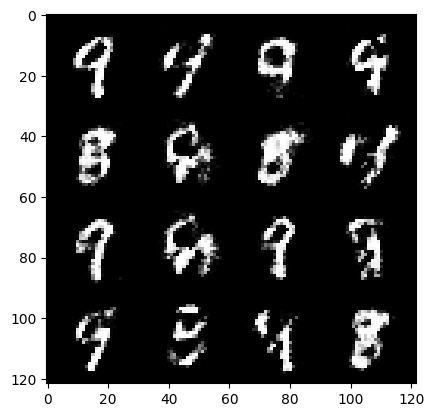

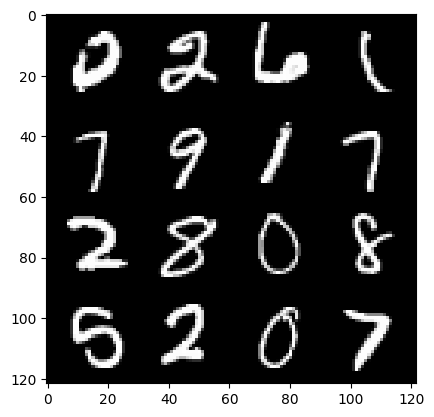

  1%|          | 3/300 [00:00<01:06,  4.48it/s]

Model saved to ./Saves/model_checkpoint_150.pth
Saved checkpoint to: checkpoint_step_45000.pth.tar


 33%|███▎      | 100/300 [00:07<00:14, 13.68it/s]

Step 46000: Generator loss: 2.24453113436699, discriminator loss: 0.5507408999800687


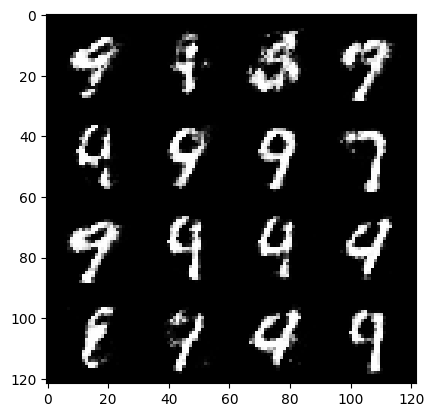

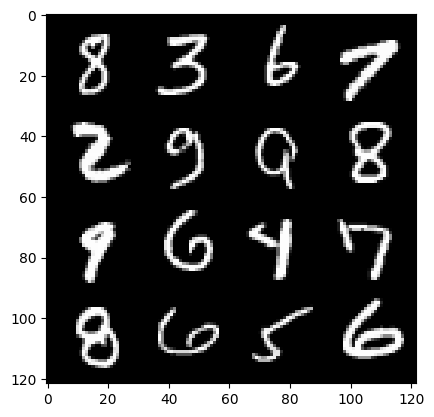

 34%|███▍      | 102/300 [00:08<00:34,  5.68it/s]

Model saved to ./Saves/model_checkpoint_153.pth
Saved checkpoint to: checkpoint_step_46000.pth.tar


 67%|██████▋   | 200/300 [00:16<00:09, 11.02it/s]

Step 47000: Generator loss: 2.1727534664869337, discriminator loss: 0.5615412594974039


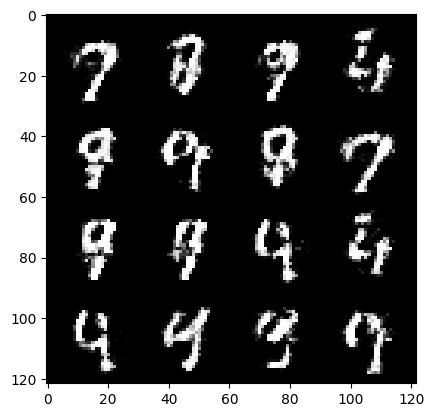

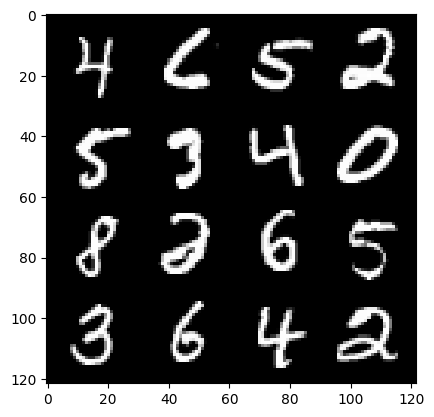

 67%|██████▋   | 202/300 [00:17<00:20,  4.71it/s]

Model saved to ./Saves/model_checkpoint_156.pth
Saved checkpoint to: checkpoint_step_47000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 48000: Generator loss: 2.1958560833930965, discriminator loss: 0.5514795638322829


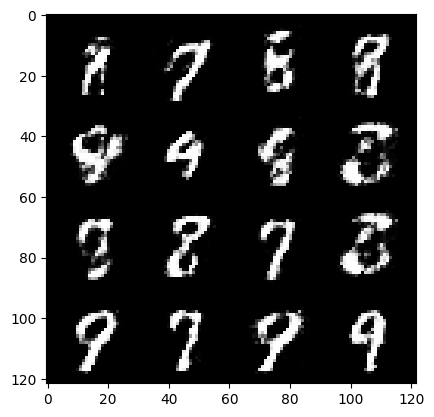

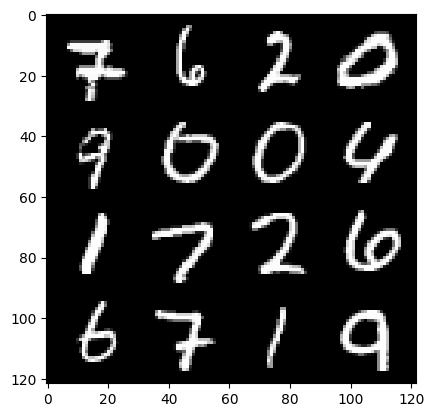

  1%|          | 3/300 [00:00<01:06,  4.44it/s]

Model saved to ./Saves/model_checkpoint_160.pth
Saved checkpoint to: checkpoint_step_48000.pth.tar


 33%|███▎      | 100/300 [00:08<00:17, 11.22it/s]

Step 49000: Generator loss: 2.162044919013976, discriminator loss: 0.5534408497512343


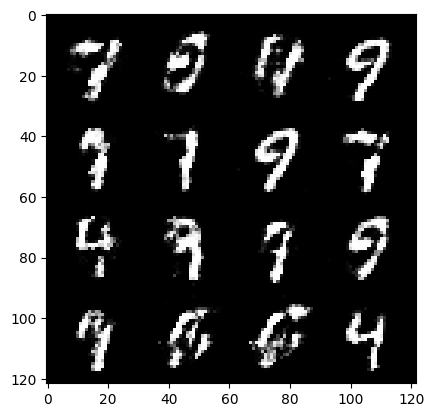

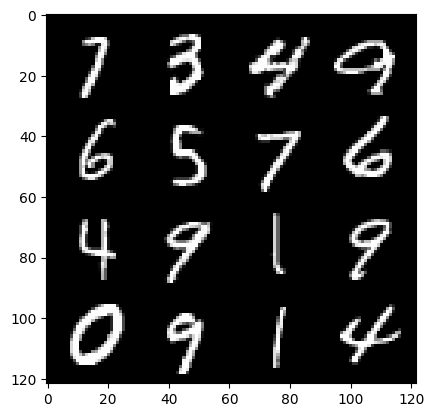

 34%|███▍      | 102/300 [00:09<00:40,  4.93it/s]

Model saved to ./Saves/model_checkpoint_163.pth
Saved checkpoint to: checkpoint_step_49000.pth.tar


 66%|██████▋   | 199/300 [00:16<00:09, 10.81it/s]

Step 50000: Generator loss: 2.1629005956649787, discriminator loss: 0.5511096115112314


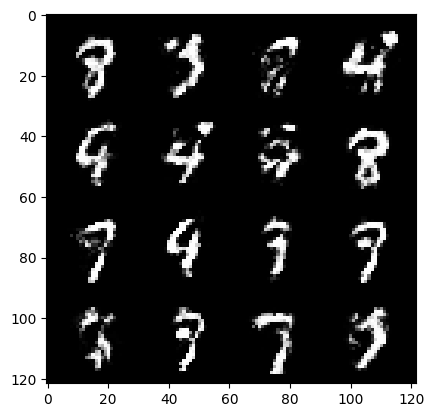

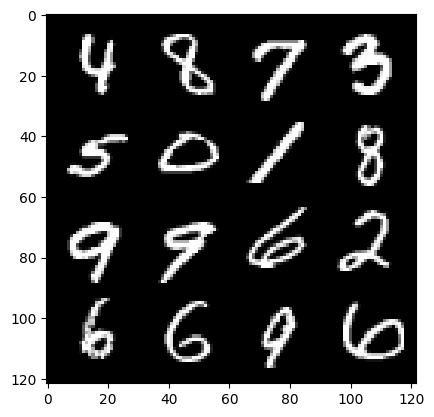

 68%|██████▊   | 203/300 [00:17<00:16,  5.93it/s]

Model saved to ./Saves/model_checkpoint_166.pth
Saved checkpoint to: checkpoint_step_50000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 51000: Generator loss: 2.0708652207851412, discriminator loss: 0.5996949120461941


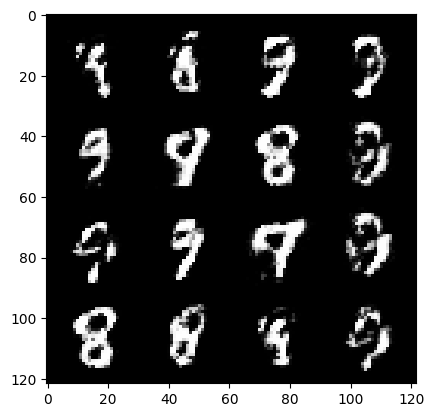

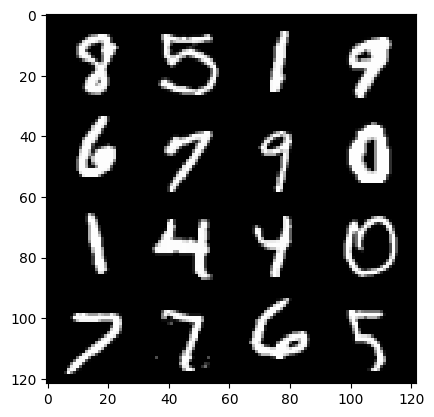

  1%|          | 3/300 [00:01<01:28,  3.37it/s]

Model saved to ./Saves/model_checkpoint_170.pth
Saved checkpoint to: checkpoint_step_51000.pth.tar


 33%|███▎      | 100/300 [00:07<00:14, 13.92it/s]

Step 52000: Generator loss: 2.0988769940137857, discriminator loss: 0.5772890793085097


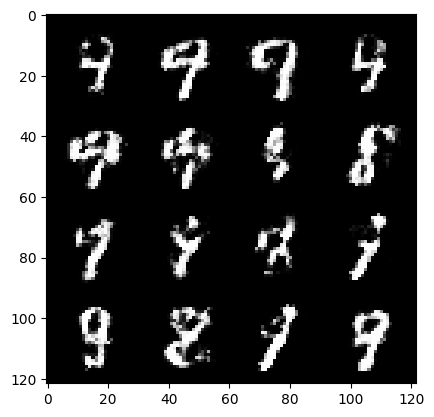

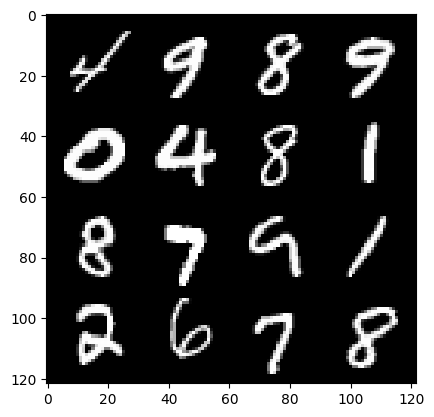

 34%|███▍      | 102/300 [00:08<00:44,  4.40it/s]

Model saved to ./Saves/model_checkpoint_173.pth
Saved checkpoint to: checkpoint_step_52000.pth.tar


 67%|██████▋   | 200/300 [00:15<00:07, 12.91it/s]

Step 53000: Generator loss: 2.2178185766935337, discriminator loss: 0.5263717847764494


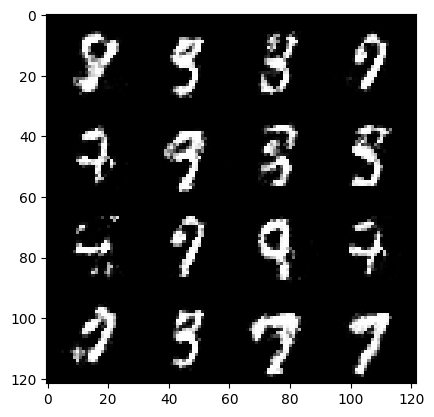

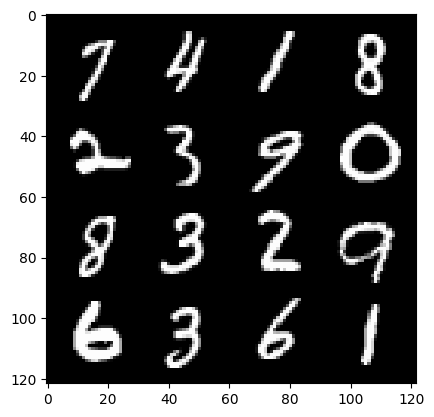

 67%|██████▋   | 202/300 [00:16<00:16,  5.95it/s]

Model saved to ./Saves/model_checkpoint_176.pth
Saved checkpoint to: checkpoint_step_53000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 54000: Generator loss: 2.0623760173320784, discriminator loss: 0.6176724131703369


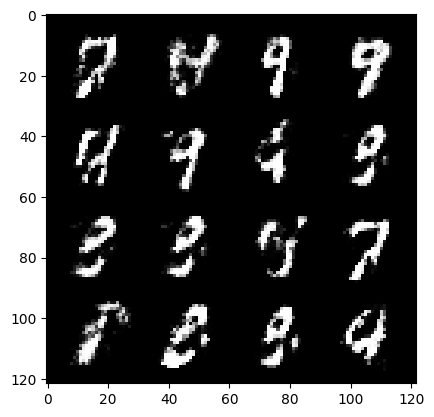

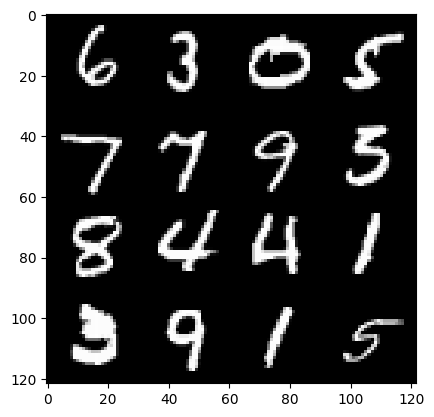

  1%|          | 2/300 [00:00<01:49,  2.73it/s]

Model saved to ./Saves/model_checkpoint_180.pth
Saved checkpoint to: checkpoint_step_54000.pth.tar


 33%|███▎      | 100/300 [00:08<00:16, 12.23it/s]

Step 55000: Generator loss: 1.9638724952936202, discriminator loss: 0.6521067416071896


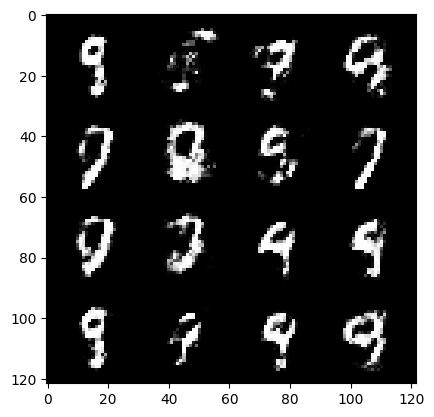

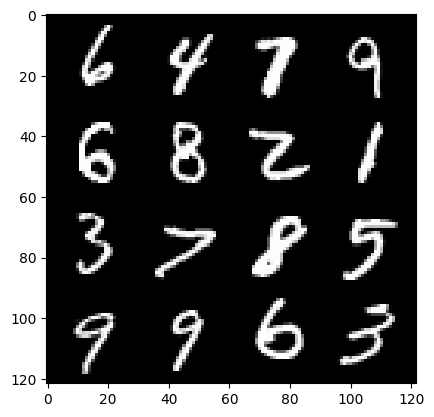

 34%|███▍      | 102/300 [00:09<00:35,  5.57it/s]

Model saved to ./Saves/model_checkpoint_183.pth
Saved checkpoint to: checkpoint_step_55000.pth.tar


 67%|██████▋   | 200/300 [00:15<00:09, 10.19it/s]

Step 56000: Generator loss: 2.0460012125968934, discriminator loss: 0.6076578507423401


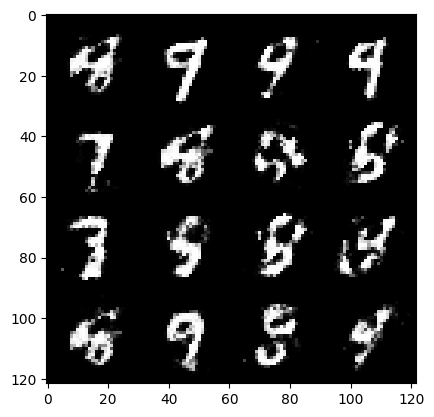

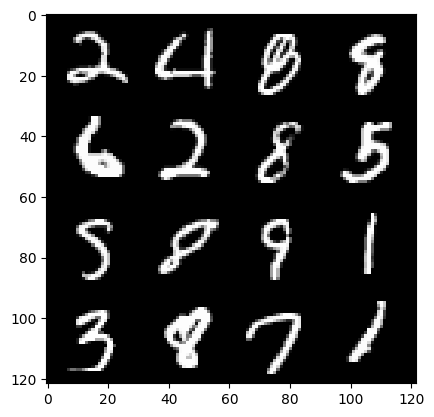

 67%|██████▋   | 202/300 [00:16<00:22,  4.44it/s]

Model saved to ./Saves/model_checkpoint_186.pth
Saved checkpoint to: checkpoint_step_56000.pth.tar


  0%|          | 0/300 [00:00<?, ?it/s]

Step 57000: Generator loss: 1.890711194872857, discriminator loss: 0.6805199261307708


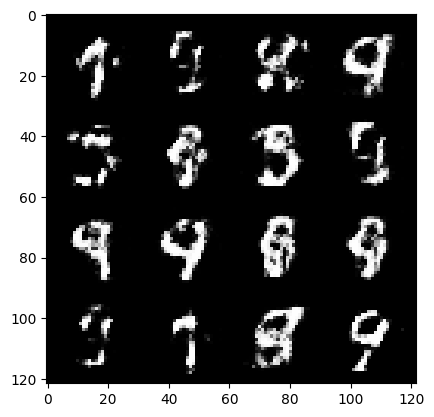

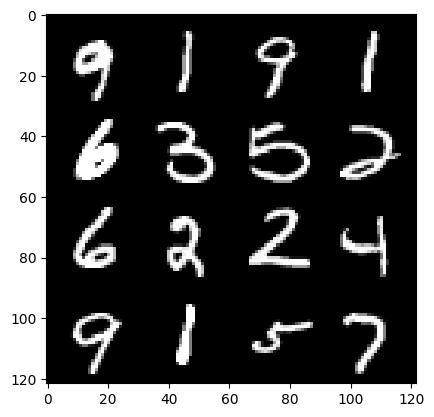

  1%|          | 3/300 [00:00<01:12,  4.08it/s]

Model saved to ./Saves/model_checkpoint_190.pth
Saved checkpoint to: checkpoint_step_57000.pth.tar


 33%|███▎      | 99/300 [00:08<00:16, 12.06it/s]

Step 58000: Generator loss: 1.922891512513158, discriminator loss: 0.652484394073486


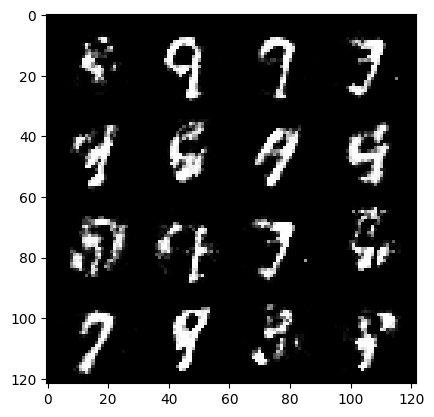

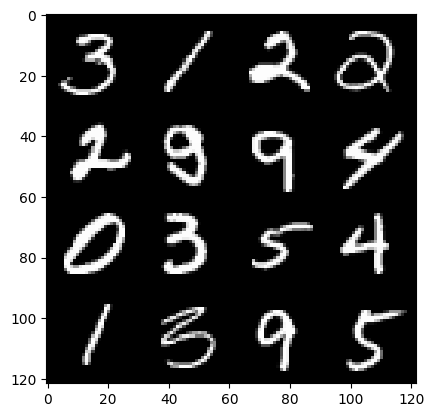

 34%|███▍      | 103/300 [00:09<00:29,  6.78it/s]

Model saved to ./Saves/model_checkpoint_193.pth
Saved checkpoint to: checkpoint_step_58000.pth.tar


 66%|██████▋   | 199/300 [00:16<00:08, 12.30it/s]

Step 59000: Generator loss: 1.871485808134081, discriminator loss: 0.674743117928505


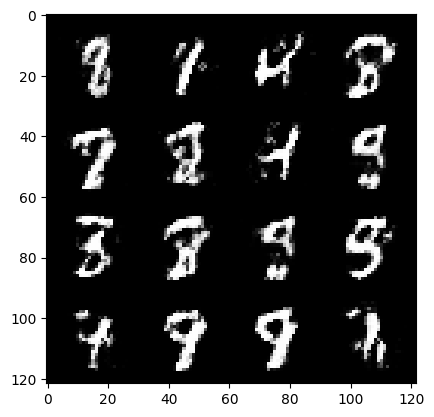

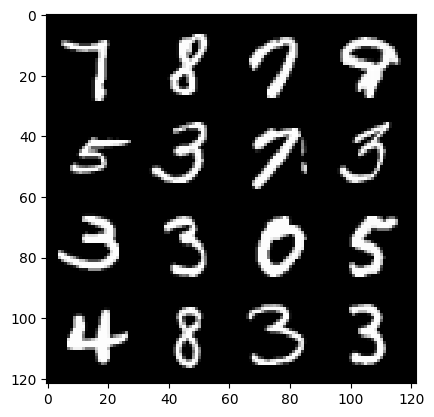

 67%|██████▋   | 202/300 [00:16<00:16,  5.82it/s]

Model saved to ./Saves/model_checkpoint_196.pth
Saved checkpoint to: checkpoint_step_59000.pth.tar


100%|██████████| 300/300 [00:23<00:00, 13.02it/s]


In [22]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
gen_loss = False

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        # get the number of images in the current batch
        # and reshape each image tensor to a 2D tensor (flatten the image)
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)

        # zero out the gradients before backpropagation
        # calculate the loss for the discriminator using real and fake images
        # backpropagate the loss to compute the gradient
        # update the discriminator's parameters using the optimizer
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, noise_dimension, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # zero out the gradients before backpropagation
        # calculate the loss for the generator by fooling the discriminator
        # backpropagate the loss to compute the gradient
        # update the generator's parameters using the optimizer
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, noise_dimension, device)
        gen_loss.backward()
        gen_opt.step()

        # Update the running average of the discriminator loss
        # by adding the current loss and normalizing by display_step
        mean_discriminator_loss += disc_loss.item() / display_step
        # update the running average of the generator loss
        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            # print the current generator and discriminator losses
            # create new noise and generate fake images from it
            # display both the generated fake images and the real images
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = create_noise(cur_batch_size, noise_dimension, device=device)
            fake = gen(fake_noise)
            tensor_to_images(fake)
            tensor_to_images(real)
            # reset the running averages after displaying
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        
        if cur_step % load_step == 0 and cur_step > 0:
            # save a checkpoint of the current model state
            # this allows resuming training later from this point
            checkpoint_filename = f"checkpoint_step_{cur_step}.pth.tar"
            save_checkpoint(gen, epoch, checkpoint_filename)
            print(f"Saved checkpoint to: {checkpoint_filename}")

        cur_step += 1